In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import rosbag
import tf.transformations as tr

In [2]:
DIR='/homeL/pr2admin/michael/data/202307 - geometry exploration eval/'

b= "guzheng_e3_2023-07-26-17-05-27.bag",
b= "guzheng_e3_2023-07-26-20-29-59.bag",
b= "guzheng_e3_2023-07-26-20-41-55.bag",
b= "guzheng_e3_2023-07-27-11-22-30.bag",
b= "guzheng_e3_2023-07-27-11-52-53.bag",
b= "guzheng_e3_2023-07-27-13-06-24.bag",
b= "guzheng_e3_2023-07-27-13-14-49.bag",

b= "guzheng_d5_2023-07-27-13-45-37.bag"
b= "guzheng_d5_2023-07-27-13-54-55.bag"

b= "guzheng_d6_2023-07-27-16-13-32.bag"

In [3]:
def string_to_note(string : str):
    return string.upper().replace('IS', u'\u266F')

def format_axis(ax):
    ax.grid()
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax.set_yticks(np.arange(0, 0.0051, 0.001))
    ax.set_ylim(0, 0.005)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{x*1000:.0f}mm'))
    ax.set_xlabel('Plucks')
    ax.set_ylabel('Onset Projection Error')

In [4]:
def process(bag_path : str, string= None):
    B= rosbag.Bag(bag_path)

    # read and prepare string fits
    Fits = [m.markers for _,m,_ in B.read_messages(topics=['/guzheng/fitted_strings'])]
    names = set()
    for m in Fits:
        names.update({f.ns for f in m[1:]})
    if string is None:
        string = Fits[0][-1].ns
    s_names = names

    F= [f for m in Fits if len(m) > 1 for f in m[1:] if f.ns == string]
    FM= np.stack([tr.translation_matrix((p.x,p.y,p.z)) @ tr.quaternion_matrix((q.x,q.y,q.z,q.w)) for p,q in
            [(m.pose.position, m.pose.orientation) for m in F]
        ])

    # read and prepare onsets
    O = [o.markers for _,o,_ in B.read_messages(topics=['/guzheng/onsets_latest'])]
    # TODO: filter out onsets of different notes
    names = set()
    for m in O:
        names.update({f.ns for f in m[1:]})
    onset = O[0][-1].ns
    o_names = names

    print(f'picked {string} and {onset} for {bag_path}; found strings: {s_names} and onsets {o_names}')
    assert(onset == string_to_note(string))

    OP= np.array([
        (p.x, p.y, p.z) for p in
            [p.pose.position for m in O for p in m if p.ns == onset if len(m) == 2]
    ])
    AffOP = np.ones((OP.shape[0], OP.shape[1]+1))
    AffOP[:,0:3] = OP

    return AffOP, FM

In [11]:
AffOP, FM = process(f'{DIR}/{b}')

picked d6 and D6 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval//guzheng_d6_2023-07-27-16-13-32.bag; found strings: {'d6', 'd5', 'unexpected f2'} and onsets {'F2', 'D♯5', 'E2', 'unknown', 'B5', 'E5', 'D5', 'D6', 'D♯3'}


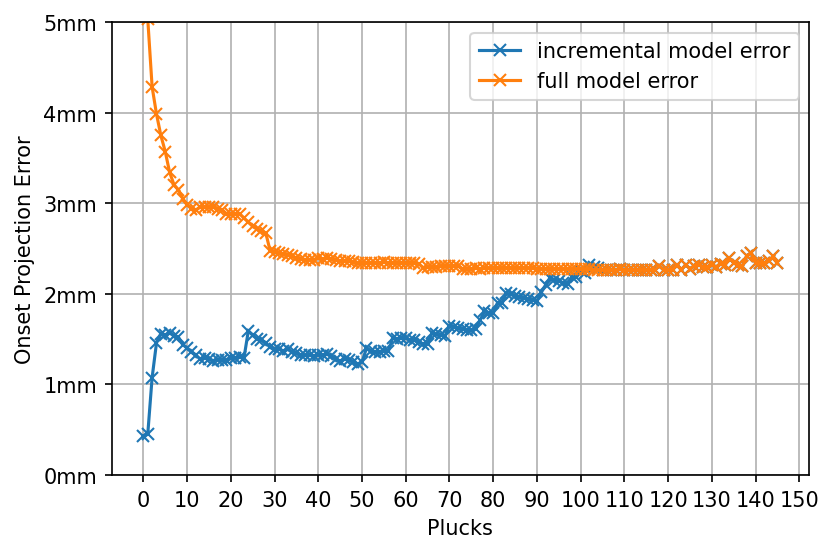

In [12]:
pts_full= [(np.array(AffOP[:,:]) @ tr.inverse_matrix(FM[i]).T)[:,0:3] for i in np.arange(len(FM)-1)+1]
means_full = np.stack([np.mean(np.linalg.norm(p[:,:2], axis=1)) for p in pts_full])

pts_inc= [(np.array(AffOP[:i,:]) @ tr.inverse_matrix(FM[i]).T)[:,0:3] for i in np.arange(len(FM)-1)+1]
means_inc = np.stack([np.mean(np.linalg.norm(p[:,:2], axis=1)) for p in pts_inc])

fig, ax = plt.subplots(dpi=150)
means_stack = np.stack((
    means_inc,
    means_full,
    ), axis=1)

df(means_stack,
    columns=[
        'incremental model error',
        'full model error',
        ]).plot(style='x-', ax=ax);
format_axis(ax)

In [5]:
def expected_future_error(AffOP, FM, W= 30):
    #assert(AffOP.shape[0] == FM.shape[0])
    pts_window= [(np.array(AffOP[i:i+W,:]) @ tr.inverse_matrix(FM[i]).T)[:,0:3] for i in np.arange(len(FM)-1-W)+1]
    means_window = np.stack([np.mean(np.linalg.norm(p[:,:2], axis=1)) for p in pts_window])
    return means_window

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


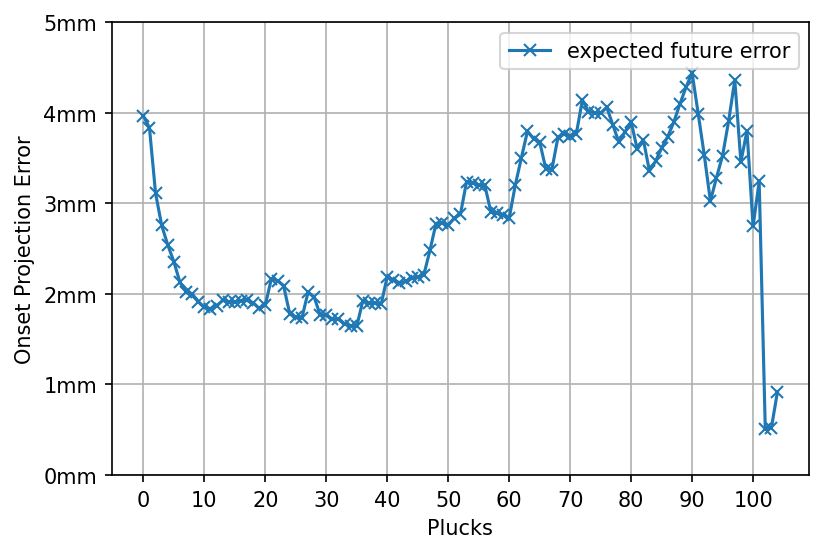

In [14]:
efe = expected_future_error(AffOP, FM)

fig, ax = plt.subplots(dpi=150)
df(efe,
    columns=[
        'expected future error'
        ]).plot(style='x-', ax=ax);
format_axis(ax)

In [ ]:
# animate for each FM
import matplotlib.animation as animation
from IPython.display import HTML, display

fig, ax = plt.subplots(dpi=100)

def animate(i):
    ax.clear()
    sns.scatterplot(x=0,y=1, hue=2, data=df((np.array(AffOP[:i,:]) @ tr.inverse_matrix(FM[i]).T)[:,0:3]), legend='brief')
    ax.set_aspect('equal')
    ax.grid()
    S= 0.01
    ax.set_xlim(-S,S)
    ax.set_xticks(np.arange(-S,S+0.001,0.005))
    ax.set_ylim(-S,S)
    ax.set_yticks(np.arange(-S,S+0.001,0.005))
    ax.set_title(f"Frame {i}")
    ax.set_xlabel("y")
    ax.set_ylabel("z")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(np.round(x*1e3))}mm"))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(np.round(x*1e3))}mm"))

ani = animation.FuncAnimation(fig, animate, frames=len(FM), interval=200)
display(HTML(ani.to_html5_video()))
plt.close()

# collected analysis

In [9]:
from collections import namedtuple
Experiment = namedtuple('Experiment', ['name', 'onsets', 'models'])

from glob import glob
def collect_experiments(path_glob : str):
    E= []
    for b in glob(path_glob):
        AffOP, FM = process(b)
        name= b[b.rfind('/')+1:-4][len('guzheng_'):]
        E.append(Experiment(name, AffOP, FM))
    E.sort(key=lambda x: x.name)
    return E

def plot(E, W=20):
    EFE = []
    for e in E:
        EFE.append(expected_future_error(e.onsets, e.models, W = W))
    EFEdf = df([efe for efe in EFE]).T
    EFEdf.columns = [e.name for e in E]

    fig, ax = plt.subplots(1,3, figsize=(15, 5), dpi=100)
    fig.suptitle('E[$|m(p) - p$|]')

    EFEdf.plot(ax=ax[0])
    format_axis(ax[0])

    EFEdf.median(axis=1,).plot(ax=ax[1], label='median')
    # fill_between quartiles
    EFEq = EFEdf.quantile([0.25, 0.75], axis=1)
    ax[1].fill_between(EFEq.columns, EFEq.loc[0.25], EFEq.loc[0.75], alpha=0.2, label='quartiles');
    format_axis(ax[1])
    ax[1].legend();

    ax[2].plot(EFEdf.index, EFEdf.mean(axis=1), label='mean')
    ax[2].fill_between(EFEdf.index, EFEdf.mean(axis=1) - EFEdf.std(axis=1), EFEdf.mean(axis=1) + EFEdf.std(axis=1), alpha=0.2, label='std')
    format_axis(ax[2])
    ax[2].legend();

In [10]:
Experiments= {} # cache for data extracted from rosbags

In [11]:
def load_n_plot(path_glob):
    if path_glob not in Experiments:
        Experiments[path_glob] = collect_experiments(path_glob)
    plot(Experiments[path_glob])

picked a5 and A5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_a5_2023-07-28-20-15-22.bag; found strings: {'a5'} and onsets {'A5', 'A♯4', 'A4'}
picked a5 and A5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_a5_2023-07-28-19-39-08.bag; found strings: {'a5'} and onsets {'A5'}
picked a5 and A5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_a5_2023-07-28-20-00-55.bag; found strings: {'a5'} and onsets {'D♯3', 'A5', 'F3', 'C1', 'A4'}
picked a5 and A5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_a5_2023-07-28-19-50-12.bag; found strings: {'a5'} and onsets {'G4', 'A5', 'E5', 'A4'}
picked a5 and A5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_a5_2023-07-28-20-27-08.bag; found strings: {'a5'} and onsets {'G4', 'A5', 'D5'}


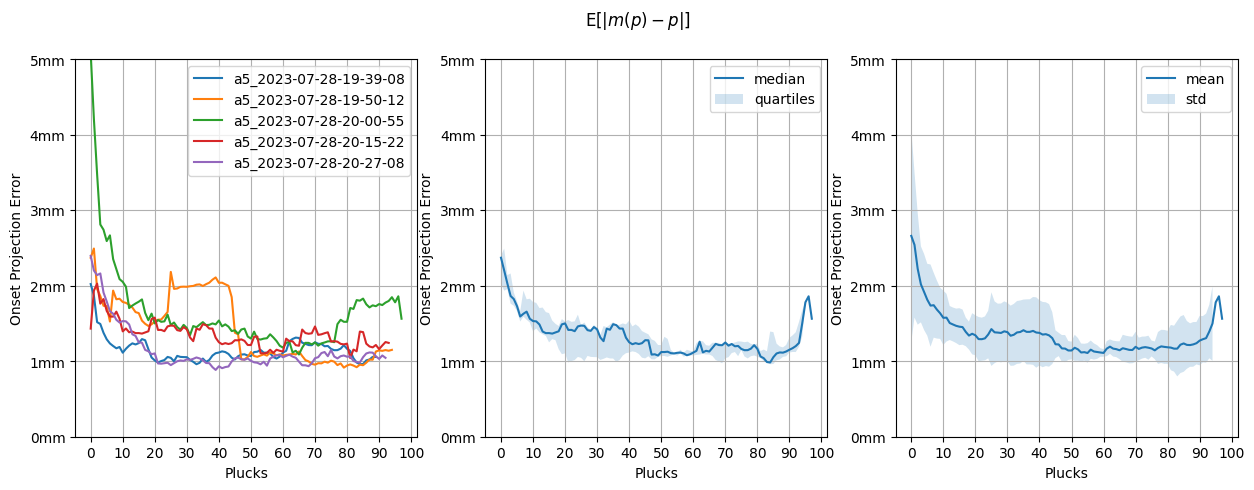

In [12]:
load_n_plot(f'{DIR}/guzheng_a5*.bag')

picked d5 and D5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_d5_2023-07-27-13-54-55.bag; found strings: {'d5'} and onsets {'B4', 'D5'}
picked d5 and D5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_d5_2023-07-27-14-05-28.bag; found strings: {'d5'} and onsets {'B4', 'D5'}
picked d5 and D5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_d5_2023-07-27-13-45-37.bag; found strings: {'d5'} and onsets {'B4', 'D5'}
picked d5 and D5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_d5_2023-07-27-14-14-14.bag; found strings: {'d5'} and onsets {'G4', 'D5', 'A♯4'}
picked d5 and D5 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_d5_2023-07-27-14-22-56.bag; found strings: {'d5'} and onsets {'B4', 'D5'}


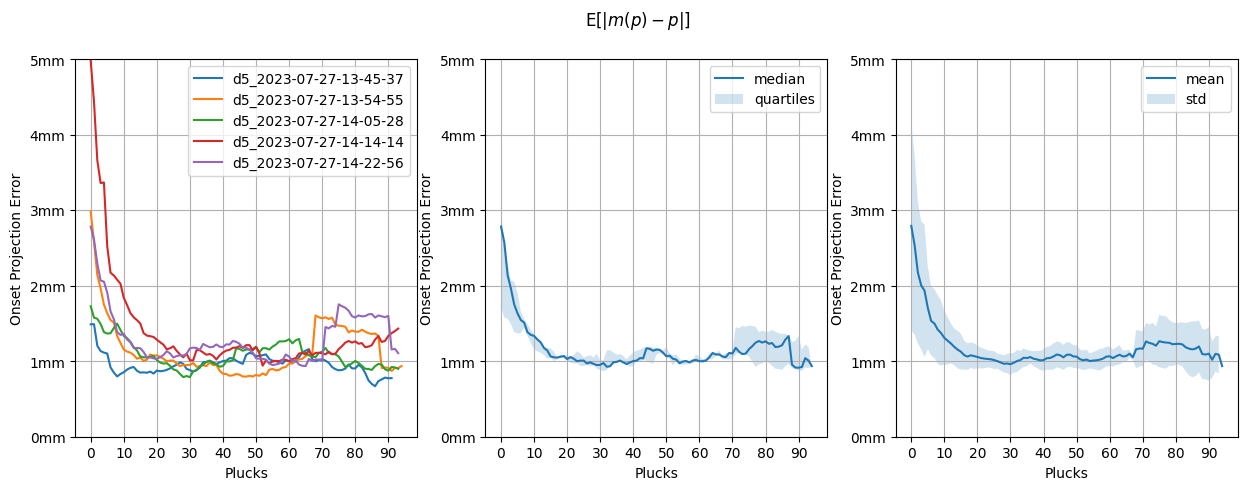

In [13]:
load_n_plot(f'{DIR}/guzheng_d5*.bag')

picked fis4 and F♯4 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_fis4_2023-07-28-16-40-20.bag; found strings: {'fis4'} and onsets {'F♯4', 'G♯4', 'A4'}
picked fis4 and F♯4 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_fis4_2023-07-28-15-56-42.bag; found strings: {'fis4'} and onsets {'G4', 'F♯4', 'G♯4'}
picked fis4 and F♯4 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_fis4_2023-07-28-16-07-13.bag; found strings: {'fis4'} and onsets {'F♯4'}
picked fis4 and F♯4 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_fis4_2023-07-28-16-19-51.bag; found strings: {'fis4'} and onsets {'F♯4', 'A4'}
picked fis4 and F♯4 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_fis4_2023-07-28-16-30-23.bag; found strings: {'fis4'} and onsets {'F♯4'}


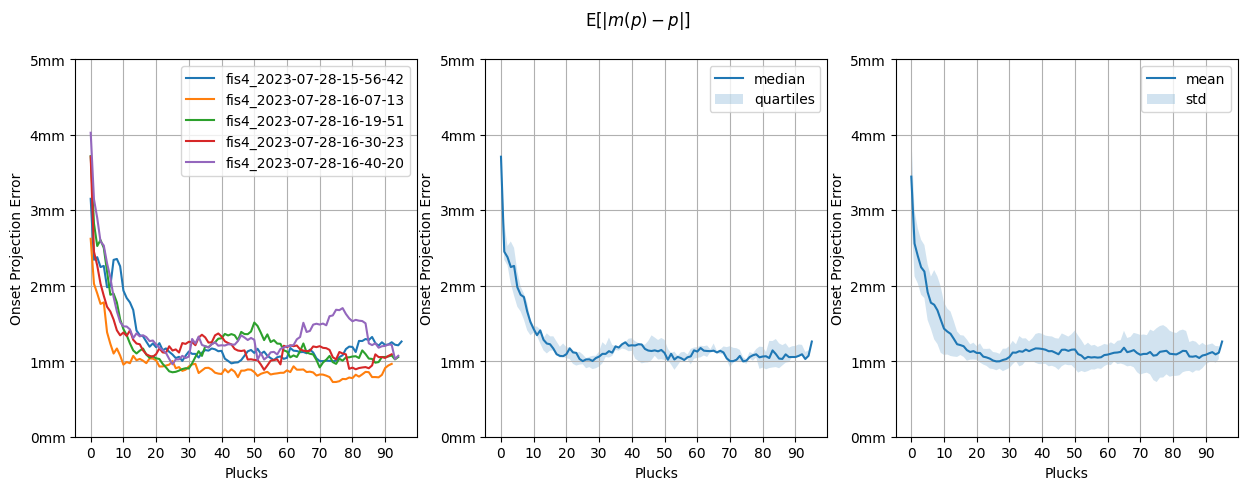

In [14]:
load_n_plot(f'{DIR}/guzheng_fis4*.bag')

picked b3 and B3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_b3_2023-07-28-17-36-17.bag; found strings: {'b3'} and onsets {'B4', 'B3'}
picked b3 and B3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_b3_2023-07-28-16-58-40.bag; found strings: {'b4', 'b3'} and onsets {'B4', 'B3', 'F2', 'A♯4', 'F♯3', 'G♯4', 'C1', 'A4'}
picked b3 and B3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_b3_2023-07-28-17-49-40.bag; found strings: {'b4', 'b3'} and onsets {'B4', 'B3'}
picked b3 and B3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_b3_2023-07-28-17-11-55.bag; found strings: {'b4', 'b3'} and onsets {'F♯4', 'F4', 'B4', 'B3'}
picked b3 and B3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_b3_2023-07-28-17-24-33.bag; found strings: {'b3'} and onsets {'unknown', 'D3', 'F4', 'G♯4', 'C1', 'B4', 'B3'}


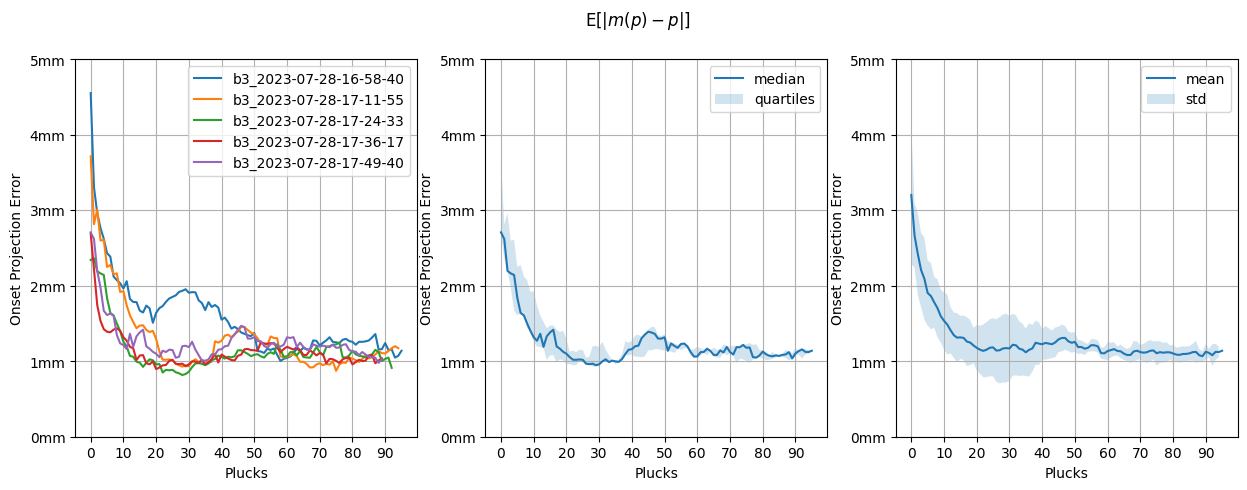

In [15]:
load_n_plot(f'{DIR}/guzheng_b3*.bag')

picked e3 and E3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_e3_2023-07-28-18-40-17.bag; found strings: {'e3'} and onsets {'F3', 'F4', 'E3'}
picked e3 and E3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_e3_2023-07-27-11-52-53.bag; found strings: {'e3'} and onsets {'F3', 'D3', 'B2', 'E3', 'C1'}
picked e3 and E3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_e3_2023-07-28-18-14-34.bag; found strings: {'e3'} and onsets {'E3'}
picked e3 and E3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_e3_2023-07-27-13-14-49.bag; found strings: {'e3', 'unexpected f3'} and onsets {'E3', 'F3'}
picked e3 and E3 for /homeL/pr2admin/michael/data/202307 - geometry exploration eval/guzheng_e3_2023-07-28-18-27-01.bag; found strings: {'e3'} and onsets {'E3'}


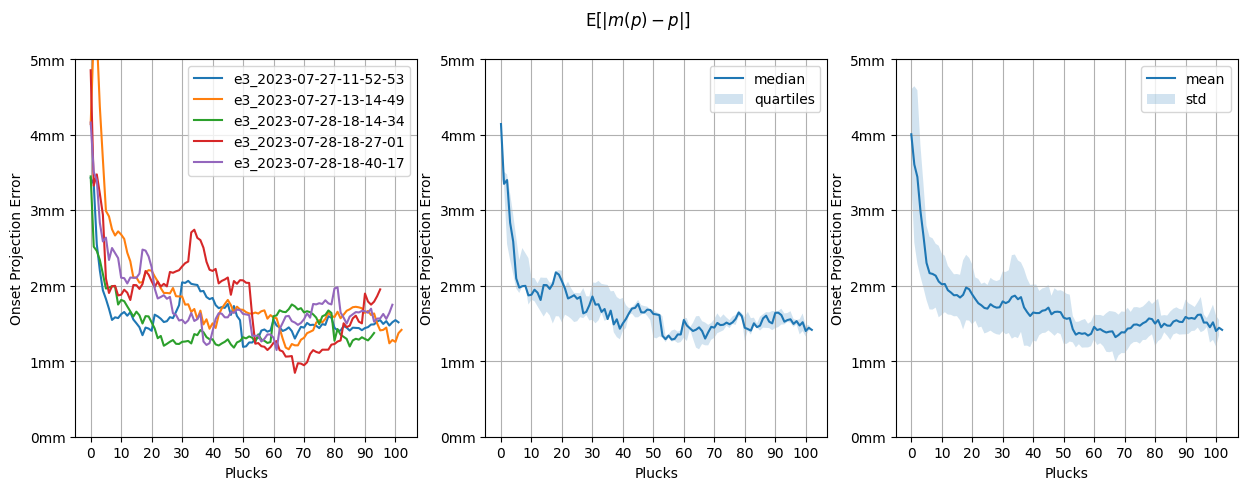

In [16]:
load_n_plot(f'{DIR}/guzheng_e3*.bag')

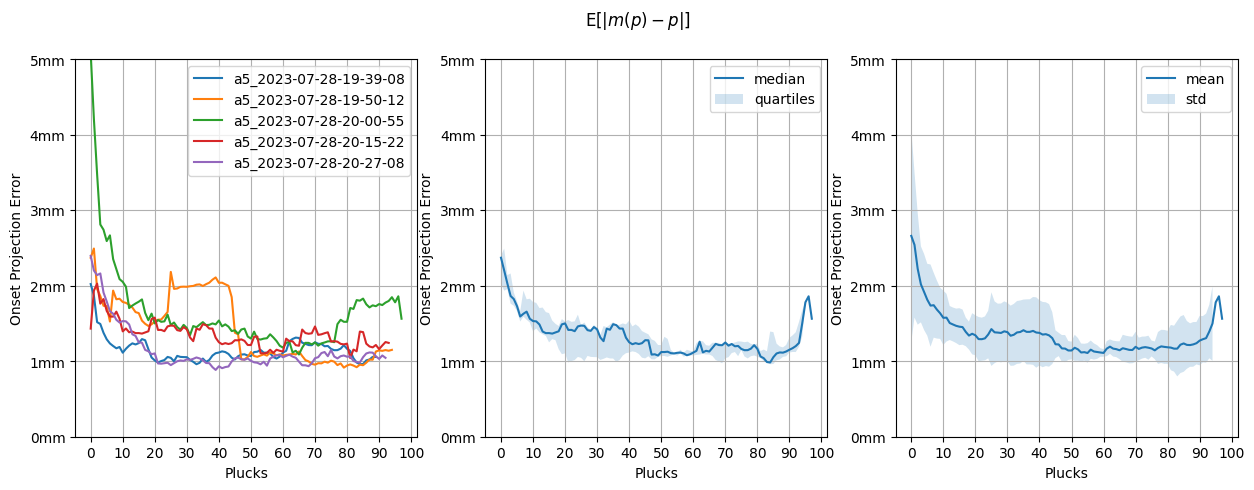

In [17]:
load_n_plot(f'{DIR}/guzheng_a5*.bag')

In [50]:
W = 50
N = 50

EEFEdf = {}
for name_glob,exp in Experiments.items():
    E = exp
    EFE = [expected_future_error(e.onsets, e.models, W = W) for e in E]
    EFEdf = df([efe for efe in EFE]).T
    EFEdf.columns = [e.name for e in E]
    name = name_glob.split('/')[-1][len('guzheng_'):][:-len('*.bag')]
    EEFEdf[name]= EFEdf

# combine columns from dataframes in EEFEdf into new dataframe
all_bags = df()
for i in EEFEdf:
    for j in EEFEdf[i]:
        all_bags[f'e{i}-{j}'] = EEFEdf[i][j]

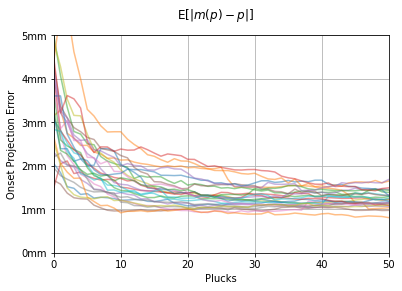

In [48]:
plt.suptitle('E[$|m(p) - p$|]') # over all episodes
ax = plt.gca()
for eef in EEFEdf.values():
    eef.plot(legend=False, ax = ax, alpha= .5)
ax.set_xlim(0,N)    
format_axis(ax)
plt.savefig(f'figures/EFE_all_W{W}.svg')

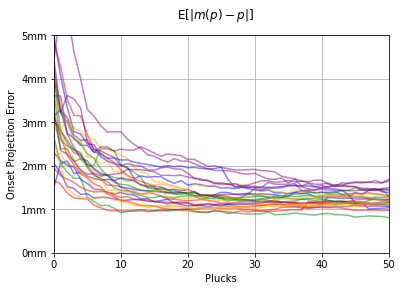

In [49]:
plt.suptitle('E[$|m(p) - p$|]') # over all episodes
ax = plt.gca()
C= ['blue', 'red', 'green', 'orange', 'purple']
for color, eef in zip(C, EEFEdf.values()):
    eef.plot(legend=False, ax = ax, alpha= .5, color=color)
ax.set_xlim(0,N)    
format_axis(ax)
plt.savefig(f'figures/EFE_all_colorgrouped_W{W}.svg')

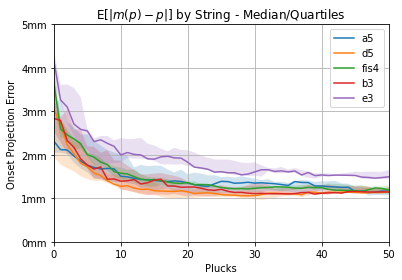

In [20]:
plt.title('E[$|m(p) - p$|] by String - Median/Quartiles')
ax = plt.gca()
for name,EFEdf in EEFEdf.items():
    EFEdf.median(axis=1,).plot(ax=ax, label=name)
    EFEq = EFEdf.quantile([0.25, 0.75], axis=1)
    ax.fill_between(EFEq.columns, EFEq.loc[0.25], EFEq.loc[0.75], alpha=0.2)
ax.set_xlim(0,N)
ax.legend()
format_axis(ax)
plt.savefig(f'figures/EFE_med_quart_per_string_W{W}.svg')

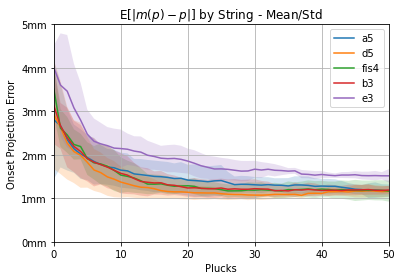

In [21]:
plt.title('E[$|m(p) - p$|] by String - Mean/Std')
ax = plt.gca()
for name,EFEdf in EEFEdf.items():
    EFEdf.mean(axis=1,).plot(ax=ax, label=name)
    EFEq = EFEdf.std(axis=1,)
    ax.fill_between(EFEq.index, EFEdf.mean(axis=1)+EFEq, EFEdf.mean(axis=1)-EFEq, alpha=0.2);
ax.set_xlim(0,N)
ax.legend()
format_axis(ax)
plt.savefig(f'figures/EFE_mean_std_per_string_W{W}.svg')

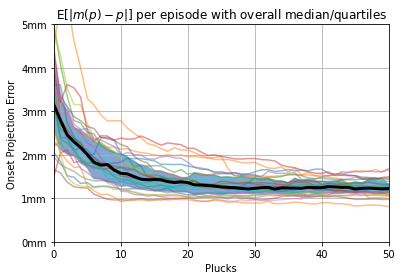

In [23]:
plt.title('E[$|m(p) - p$|] per episode with overall median/quartiles')
ax = plt.subplot(111)
for eef in EEFEdf.values():
    eef.plot(legend=False, ax = ax, alpha= .5)

all_bags.median(axis=1,).plot(ax=ax, lw=3, color='k')
EFEq = all_bags.quantile([0.25, 0.75], axis=1)
ax.fill_between(EFEq.columns, EFEq.loc[0.25], EFEq.loc[0.75], alpha=0.6)

format_axis(ax)
ax.set_xlim(0, N)

plt.savefig(f'figures/EFE_all_with_med_quart_W{W}.svg')

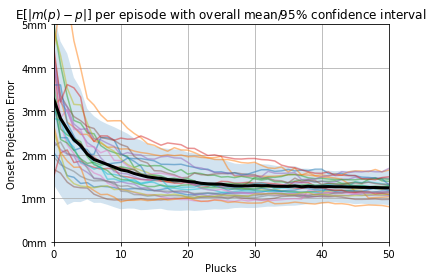

In [24]:
plt.title('E[$|m(p) - p$|] per episode with overall mean/95% confidence interval')
ax = plt.subplot(111)
for eef in EEFEdf.values():
    eef.plot(legend=False, ax = ax, alpha= .5)

all_bags.mean(axis=1,).plot(ax=ax, lw=3, color='k')
EFEq = all_bags.std(axis=1,)*1.96
ax.fill_between(EFEq.index, all_bags.mean(axis=1)+EFEq, all_bags.mean(axis=1)-EFEq, alpha=0.2);

format_axis(ax)
ax.set_xlim(0, N)

plt.savefig(f'figures/EFE_all_with_mean_std_W{W}.svg')